# How to calculate roundness and sphericity

In [6]:
import numpy as np
import math
import random
import seaborn
from skimage import morphology
from skimage import measure
from scipy import ndimage
from scipy import misc
import matplotlib.pyplot as plt

maxr = 60

In [7]:
def calculate_roundness_via_perimeter(image):
    ''' Calculation of roundness via area and perimeter. '''
    area = np.sum(np.float32(image))
    perimeter = measure.perimeter(image)
    return perimeter / math.sqrt(4 * math.pi * area)

In [8]:
def get_disk_image(r, nledges = 0, ncavities = 0, nholes = 0):
    ''' Function for generation of binary image with disk where r is radius.
        Additinally several distortions such as ledges, cavities on boundary and holes can be added.
    '''
    imdimentions = 3 * r + 2
    x, y = np.indices((imdimentions, imdimentions))
    xc = imdimentions//2
    yc = imdimentions//2
    image = np.uint8((x - xc)**2 + (y - yc)**2 <= r**2)
    if r > 6:
        rhole = max(1, r//15)
        for i in range(0, nholes):
            shift = random.randint(2,r//2)
            hole = np.uint8((x - xc + shift)**2 + (y - yc)**2 > rhole**2)
            image = np.logical_and(image, hole).astype(np.uint8)
            image = misc.imrotate(image, random.randint(30,70), interp='nearest')
    if r > 2:  
        for i in range(0, nledges):
            image[yc - 1:yc + 2, xc + r - 2:xc + r + (r//10) + 2] = 1
            image = misc.imrotate(image, random.randint(30,70), interp='nearest')
        for i in range(0, ncavities):
            image[yc - 1:yc + 2, xc + r - (r//10):xc + r + 1] = 0
            image = misc.imrotate(image, random.randint(30,70), interp='nearest')    
    return image

Let's calculate roundness via perimeter for disks without distortions
<script src="https://npmcdn.com/jupyter-js-widgets@~1.2.0/dist/embed.js"></script><script type="application/vnd.jupyter-embedded-widgets">{}</script>

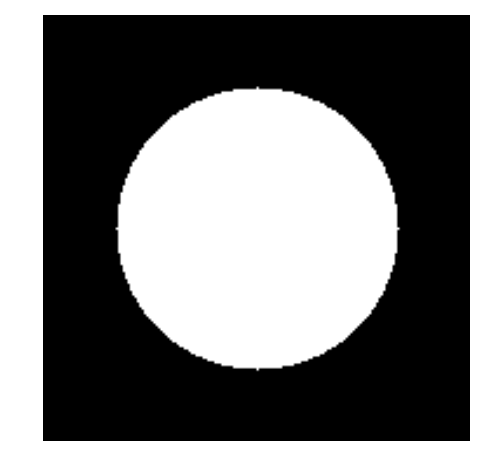

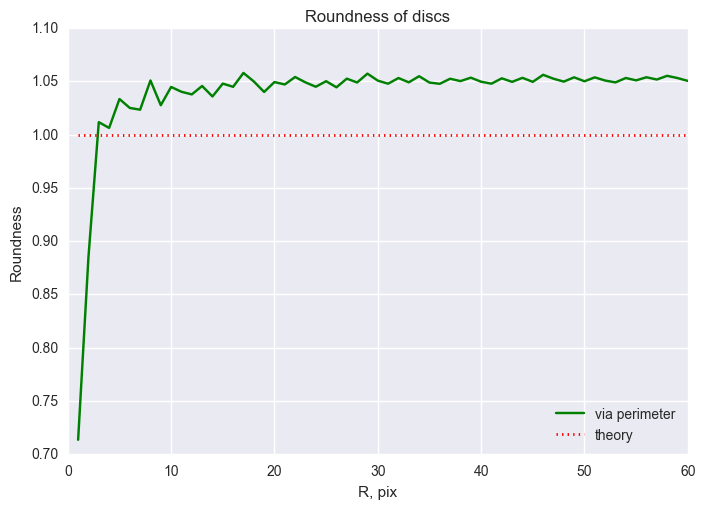

In [9]:
radiuses = range(1, maxr + 1)
idealperimeter = []
idealarea = [] 
roundness_perimeter = []
roundness_ideal = []
# calculation for various radiuses
for r in radiuses:
    image = get_disk_image(r)
    idealperimeter.append(2. * math.pi * r)
    idealarea.append(math.pi * r * r) 
    roundness_perimeter.append(calculate_roundness_via_perimeter(image))
    roundness_ideal.append(idealperimeter[-1] / math.sqrt(4 * math.pi * idealarea[-1]))
# draw image
plt.imshow(image, cmap = plt.cm.gray), plt.axis('off')
plt.show()
# draw plot
plt.plot(radiuses, roundness_perimeter, "g-", label = "via perimeter")
plt.plot(radiuses, roundness_ideal, "r:", label = "theory", linewidth = 2)
plt.xlabel("R, pix"), plt.ylabel("Roundness")
plt.legend(loc = 4)
plt.title('Roundness of discs')
#plt.savefig('d:\\proppant\\test.eps',format='eps', dpi=300)
plt.show()


Why roundness is unstable and deffer from theoretical value?
Let's check areas and perimeters in comparison with theory. 

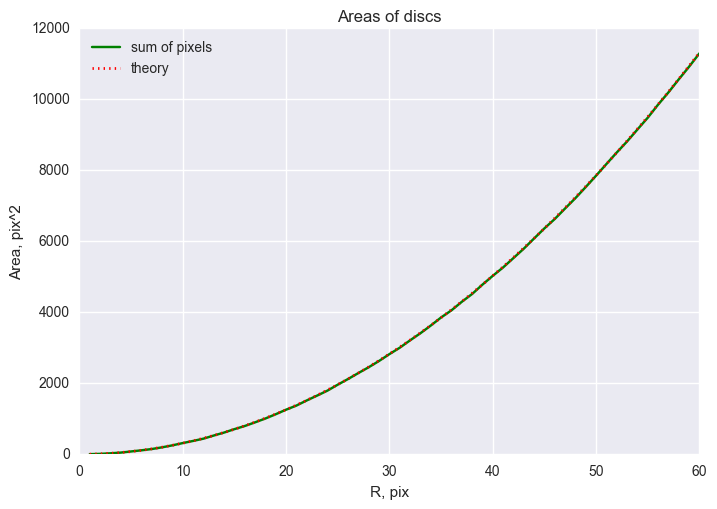

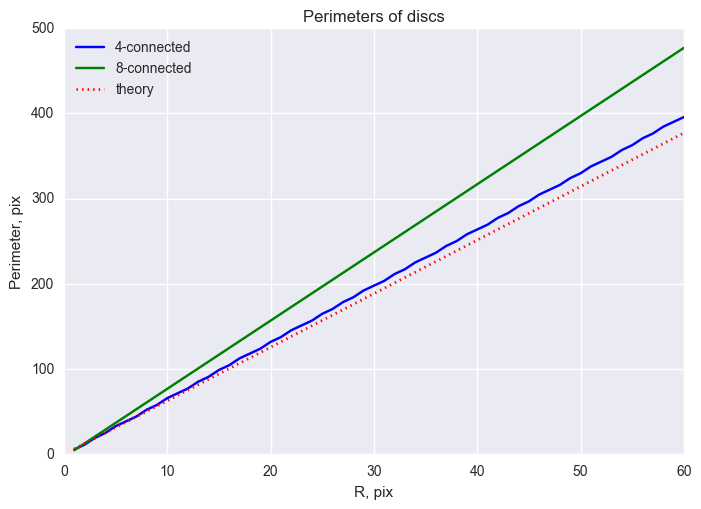

In [10]:
perimeter4 = [] 
perimeter8 = []
area = []
# calculation for various radiuses
for r in radiuses:
    image = get_disk_image(r)
    perimeter4.append( measure.perimeter(image, neighbourhood = 4))
    perimeter8.append( measure.perimeter(image, neighbourhood = 8))
    area.append(np.sum(image))

plt.plot(radiuses, area, "g-", label = "sum of pixels")
plt.plot(radiuses, idealarea, "r:", label = "theory", linewidth = 2)
plt.xlabel("R, pix"), plt.ylabel("Area, pix^2")
plt.legend(loc = 2)
plt.title('Areas of discs')
plt.show()
 
plt.plot(radiuses, perimeter4, "b-", label = "4-connected")
plt.plot(radiuses, perimeter8, "g-", label = "8-connected") 
plt.plot(radiuses, idealperimeter, "r:", label = "theory", linewidth = 2)
plt.xlabel("R, pix"), plt.ylabel("Perimeter, pix")
plt.legend(loc = 2)
plt.title('Perimeters of discs')
plt.show()

Area is OK, but perimeters are inconsistent to theoretical values, especially 8-connected (for scipy.measure.perimeter function). 

What can we do? There is way for calculation of roundness via normalized central second order moments. 

In [11]:
def calculate_roundness_via_moments(image):
    ''' Calculation of roundness via normalized central second order moments (or Hu-invariants).'''
    assert len(image.shape) == 2 # only for 2D images 
    mu = measure.moments(np.uint8(image),order = 1)
    mu_c = measure.moments_central(np.uint8(image), mu[0,1] / mu[0,0], mu[1,0] / mu[0,0], order = 2)
    return (2 * math.pi * (mu_c[0,2] + mu_c[2,0]) / (mu[0,0]**2))

# potentially it is possible to use other Hu's moments, but it produces a little bit higher computational error 
# due to a power
def calculate_roundness_via_moments2(image): 
    assert len(image.shape) == 2 # only for 2D images 
    mu = measure.moments(np.uint8(image),order = 1)
    mu_c = measure.moments_central(np.uint8(image),mu[0,1]/mu[0,0], mu[1,0]/mu[0,0], order = 2)
    return (79. * (mu_c[0,2]**2 + mu_c[2,0]**2 + 2*mu_c[1,1]**2) / (mu[0,0]**4))

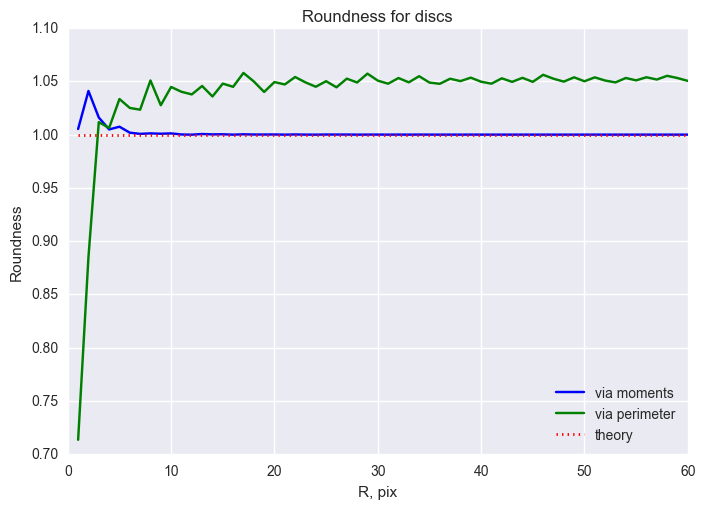

In [12]:
roundness_moments = []
# calculation for various radiuses
for r in radiuses:
    image = get_disk_image(r)
    roundness_moments.append(calculate_roundness_via_moments(image))
# draw plots
plt.plot(radiuses, roundness_moments, "b-", label = "via moments")
plt.plot(radiuses, roundness_perimeter, "g-", label = "via perimeter")
plt.plot(radiuses, roundness_ideal, "r:", label = "theory", linewidth = 2)
plt.xlabel("R, pix"), plt.ylabel("Roundness")
plt.legend(loc = 4)
plt.title('Roundness for discs')
plt.show()

Roundness based on moments looks much better (except disks with extremely small radius). 
How does it work for disks with distorted edge?

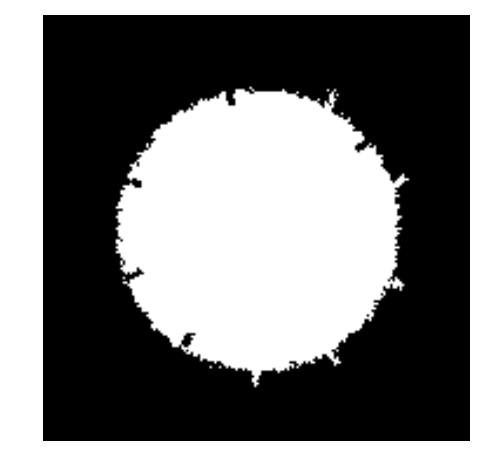

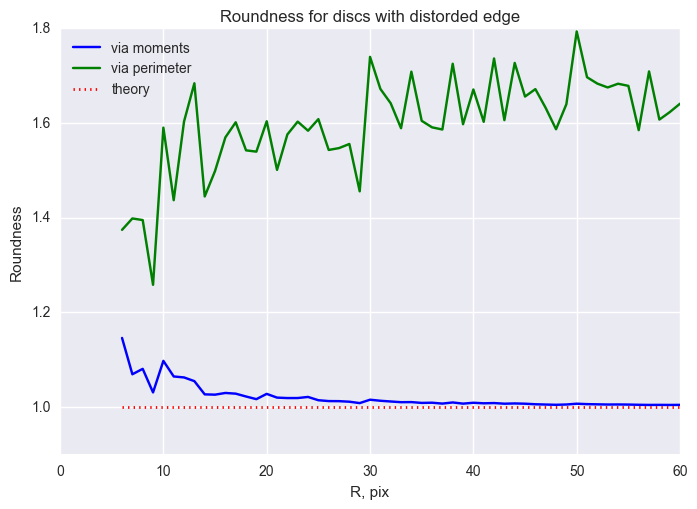

In [13]:
radiuses = range(6, maxr + 1)
idealperimeter = []
idealarea = [] 
roundness_moments = []
roundness_perimeter = []
roundness_ideal = []
# calculation for various radiuses
for r in radiuses:
    image = get_disk_image(r, nledges = 5, ncavities = 5)
    idealperimeter.append(2. * math.pi * r)
    idealarea.append(math.pi * r * r) 
    roundness_moments.append(calculate_roundness_via_moments(image))
    roundness_perimeter.append(calculate_roundness_via_perimeter(image))
    roundness_ideal.append(idealperimeter[-1] / math.sqrt(4 * math.pi * idealarea[-1]))
# show image
plt.imshow(image, cmap = plt.cm.gray), plt.axis('off')
plt.show()
# draw plots
plt.plot(radiuses, roundness_moments, "b-", label = "via moments")
plt.plot(radiuses, roundness_perimeter, "g-", label = "via perimeter")
plt.plot(radiuses, roundness_ideal, "r:", label = "theory", linewidth = 2)
plt.xlabel("R, pix"), plt.ylabel("Roundness")
plt.legend(loc = 2)
plt.title('Roundness for discs with distorded edge')
plt.show()

Method based on perimeters calculation provides inappropriate outcome. 
Roundness via moments are robust enough. 
Let's add holes.

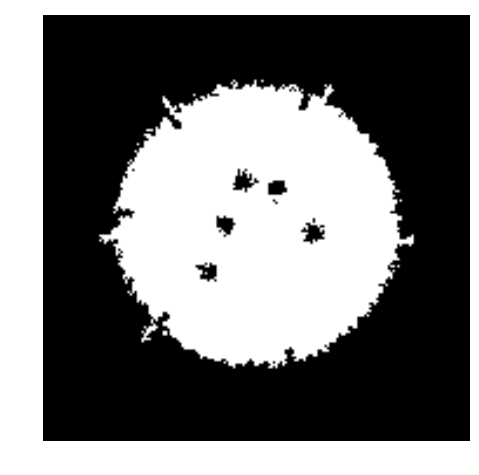

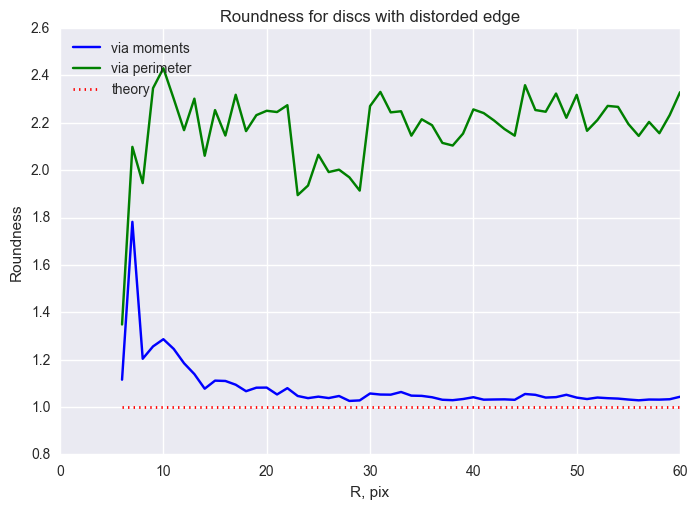

In [14]:
radiuses = range(6, maxr + 1)
idealperimeter = []
idealarea = [] 
roundness_moments = []
roundness_perimeter = []
roundness_ideal = []
# calculation for various radiuses
for r in radiuses:
    image = get_disk_image(r, nledges = 5, ncavities = 5, nholes = 5)
    idealperimeter.append(2. * math.pi * r)
    idealarea.append(math.pi * r * r) 
    roundness_moments.append(calculate_roundness_via_moments(image))
    roundness_perimeter.append(calculate_roundness_via_perimeter(image))
    roundness_ideal.append(idealperimeter[-1] / math.sqrt(4 * math.pi * idealarea[-1]))
# show image
plt.imshow(image, cmap = plt.cm.gray), plt.axis('off')
plt.show()
# draw plot
plt.plot(radiuses, roundness_moments, "b-", label = "via moments")
plt.plot(radiuses, roundness_perimeter, "g-", label = "via perimeter")
plt.plot(radiuses, roundness_ideal, "r:", label = "theory", linewidth = 2)
plt.xlabel("R, pix"), plt.ylabel("Roundness")
plt.legend(loc = 2)
plt.title('Roundness for discs with distorded edge')
plt.show()

Both approaches for roundness calculation are getting worse (please, see on value of roundness), but roundness via moments remains more or less appropriate. In any case, it is necessary to fill holes beforehand. 

How do the two measure allow to distinguish round and non-round areas? Let's consider disks and half of disks and compare absolute differences for roundnesses.

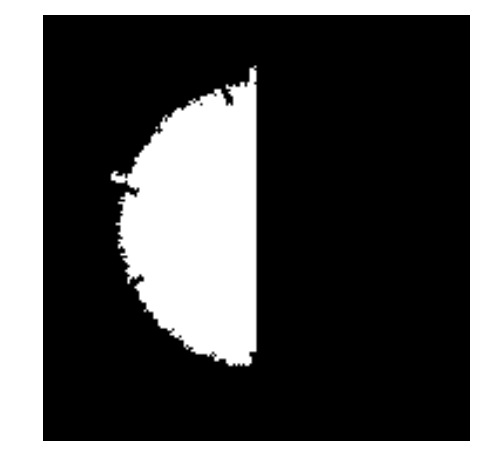

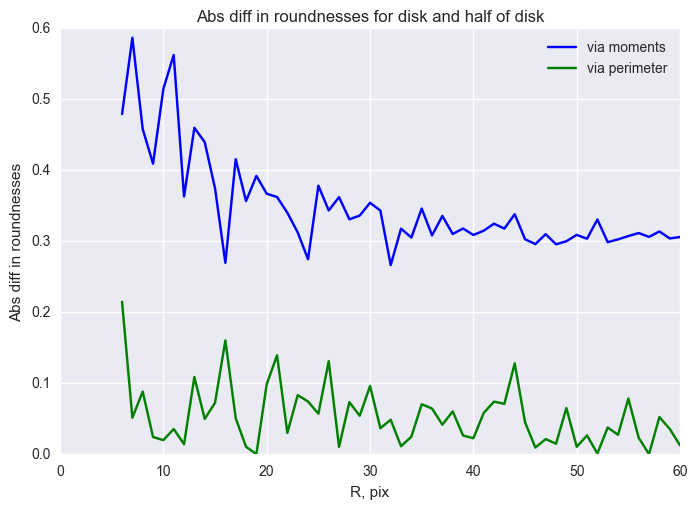

In [15]:
radiuses = range(6, maxr + 1)
diff_roundness_moments = []
diff_roundness_perimeter = []
# calculation for various radiuses
for r in radiuses:
    image = get_disk_image(r, nledges = 5, ncavities = 5)
    half_image = np.zeros(image.shape, dtype = np.uint8) 
    half_image[:,:image.shape[1]//2] = image[:,:image.shape[1]//2] 
    diff_roundness_moments.append(abs(calculate_roundness_via_moments(half_image) 
                                      - calculate_roundness_via_moments(image)))
    diff_roundness_perimeter.append(abs(calculate_roundness_via_perimeter(half_image) 
                                        - calculate_roundness_via_perimeter(image)))
# show image
plt.imshow(half_image, cmap = plt.cm.gray), plt.axis('off')
plt.show()
# draw plots
plt.plot(radiuses, diff_roundness_moments, "b-", label = "via moments")
plt.plot(radiuses, diff_roundness_perimeter, "g-", label = "via perimeter")
plt.xlabel("R, pix"), plt.ylabel("Abs diff in roundnesses")
plt.legend(loc = 1)
plt.title('Abs diff in roundnesses for disk and half of disk')
plt.show()

Difference for roundnesses based on perimeter is too insufficient in order to distinguish disk and half-of-disk. 
Difference for roundnesses based on moments is OK.
Let's see how roundness changes when we cut part of disk.

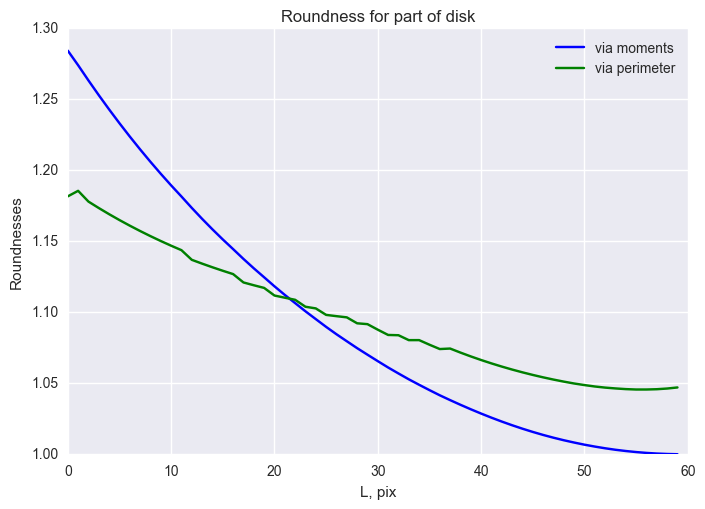

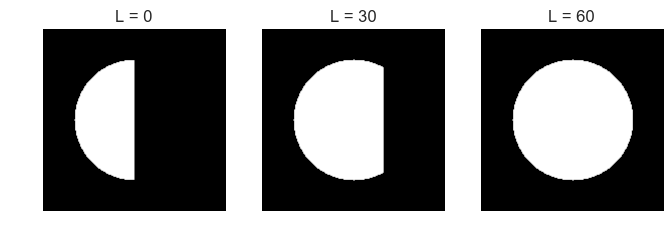

In [16]:
length_cutted_part = range(0, maxr)
roundness_moments = []
roundness_perimeter = []
image = get_disk_image(maxr, nledges = 0, ncavities = 0)
# calculation for various radiuses
for part in length_cutted_part:
    part_image = np.zeros(image.shape, dtype = np.uint8) 
    part_image[:,:image.shape[1]//2 + part] = image[:,:image.shape[1]//2 + part] 
    roundness_moments.append(calculate_roundness_via_moments(part_image))
    roundness_perimeter.append(calculate_roundness_via_perimeter(part_image))
# draw plots
plt.plot(length_cutted_part, roundness_moments, "b-", label = "via moments")
plt.plot(length_cutted_part, roundness_perimeter, "g-", label = "via perimeter")
#plt.ylim([1, 2])
plt.xlabel("L, pix"), plt.ylabel("Roundnesses")
plt.legend(loc = 1)
plt.title('Roundness for part of disk')
plt.show()
# show images
ax1 = plt.subplot(1, 3, 1)
part_image = np.zeros(image.shape, dtype = np.uint8) 
part_image[:,:image.shape[1]//2 + 0] = image[:,:image.shape[1]//2 + 0] 
ax1.imshow(part_image, cmap = plt.cm.gray), ax1.axis('off'), ax1.set_title('L = 0')
ax2 = plt.subplot(1, 3, 2)
part_image = np.zeros(image.shape, dtype = np.uint8) 
part_image[:,:image.shape[1]//2 + maxr//2] = image[:,:image.shape[1]//2 + maxr//2] 
ax2.imshow(part_image, cmap = plt.cm.gray), ax2.axis('off'), ax2.set_title('L = 30')
ax2 = plt.subplot(1, 3, 3)
part_image = np.zeros(image.shape, dtype = np.uint8) 
part_image[:,:image.shape[1]//2 + maxr] = image[:,:image.shape[1]//2 + maxr]
ax2.imshow(part_image, cmap = plt.cm.gray), ax2.axis('off'), ax2.set_title('L = 60')
plt.show()

What about sphericity in 3D? Plenty publications depict sphericity as 36*Pi*V^2 / A^3, where V is volume, A is surface area. The measure has the same drawbacks as roundness based on perimeter. From other hand, sphericity based on normalized central moments of second order can be proposed. 
Let's repeat our investigation for balls.

In [17]:
# function for generation of binary ball image with r radius
# it is possible to add ledges and cavities on boundary
def get_ball_image(r, add_artifacts = False):
    imdimentions = 3 * r + 2
    x, y, z = np.indices((imdimentions, imdimentions, imdimentions))
    xc = imdimentions//2
    yc = imdimentions//2
    zc = imdimentions//2
    image = np.uint8((x - xc)**2 + (y - yc)**2 + (z - zc)**2 <= r**2)
    if add_artifacts == True :
        slice = get_disk_image(r, nledges = 5, ncavities = 5)
        image[zc] = slice
        slice = get_disk_image(r, nledges = 5, ncavities = 5)
        image[:,yc,:] = slice
        slice = get_disk_image(r, nledges = 5, ncavities = 5)
        image[:,:,xc] = slice
    return image

In [18]:
def calculate_sphericirty_via_surfacearea(image, via_erosion = True, connectivity = 1):
    ''' Calculation of sphericity via surface area and volume. '''
    volume = np.sum(np.float32(image))
    if via_erosion == True :
        surface_image = \
        image - ndimage.binary_erosion(image, structure = ndimage.generate_binary_structure(3,connectivity))
    else :
        surface_image = \
        ndimage.binary_dilation(image, structure = ndimage.generate_binary_structure(3,connectivity)) - image
    surface_area = np.sum(np.float32(surface_image))
    return (36. * math.pi * volume**2) / (surface_area**3) 

In [19]:
def calculate_sphericity_via_moments(image):
    ''' Calculation of sphericity via normalized central second order moments. '''
    assert len(image.shape) == 3 # only for 3D images 
    z, y, x = np.mgrid[:image.shape[2], :image.shape[1], :image.shape[0]]
    image = np.float32(image)
    mu000 = np.sum(image)
    meanx = np.sum(x * image) / mu000
    meany = np.sum(y * image) / mu000
    meanz = np.sum(z * image) / mu000
    mu200 = np.sum((x - meanx)**2 * image)
    mu020 = np.sum((y - meany)**2 * image)
    mu002 = np.sum((z - meanz)**2 * image)
    return 4.3309 * (mu200 + mu020 + mu002) / (mu000**(5. / 3.))    

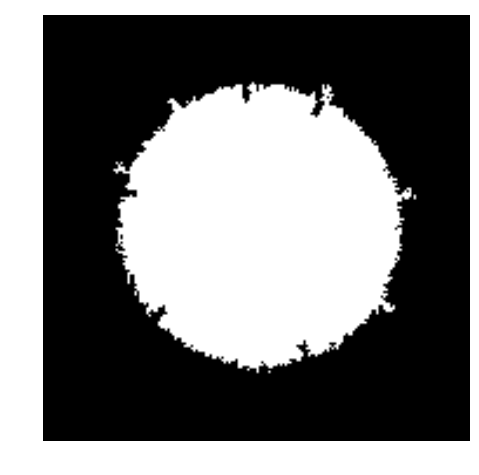

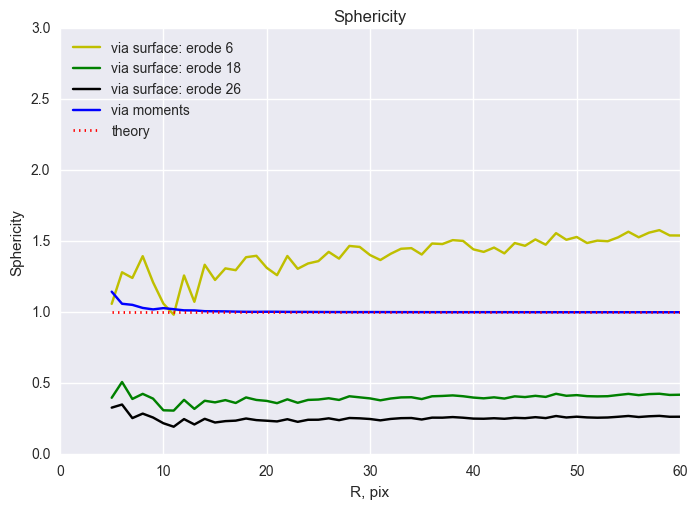

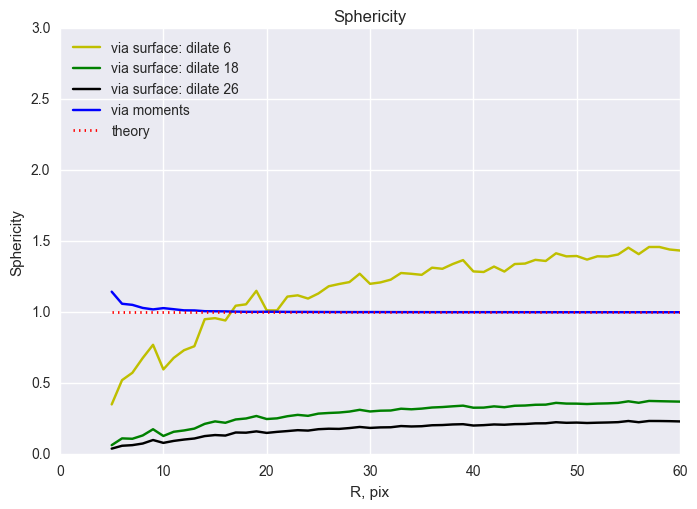

In [20]:
radiuses = range(5, maxr + 1)
idealsphericity = [] 
sphericity_erode_6 = [] 
sphericity_erode_18 = []
sphericity_erode_26 = []
sphericity_dilate_6 = [] 
sphericity_dilate_18 = []
sphericity_dilate_26 = []
sphericity_moments = []
# calculation for various radiuses
for r in radiuses:
    image = get_ball_image(r, add_artifacts = True)
    idealsphericity.append(36. * math.pi * (4. * math.pi * r**3 / 3.)**2 / (4. * math.pi * r**2)**3)
    sphericity_erode_6.append(calculate_sphericirty_via_surfacearea(image, connectivity = 1)) 
    sphericity_erode_18.append(calculate_sphericirty_via_surfacearea(image, connectivity = 2)) 
    sphericity_erode_26.append(calculate_sphericirty_via_surfacearea(image, connectivity = 3)) 
    sphericity_dilate_6.append(calculate_sphericirty_via_surfacearea(image, via_erosion = False,connectivity = 1)) 
    sphericity_dilate_18.append(calculate_sphericirty_via_surfacearea(image, via_erosion = False, connectivity = 2)) 
    sphericity_dilate_26.append(calculate_sphericirty_via_surfacearea(image, via_erosion = False, connectivity = 3)) 
    sphericity_moments.append(calculate_sphericity_via_moments(image)) 
# show slice of 3D image 
plt.imshow(image[image.shape[2]//2], cmap = plt.cm.gray), plt.axis('off')
plt.show()
# draw plots
plt.plot(radiuses, sphericity_erode_6, "y-", label = "via surface: erode 6")
plt.plot(radiuses, sphericity_erode_18, "g-", label = "via surface: erode 18")
plt.plot(radiuses, sphericity_erode_26, "k-", label = "via surface: erode 26")
plt.plot(radiuses, sphericity_moments, "b-", label = "via moments")
plt.plot(radiuses, idealsphericity, "r:", label = "theory", linewidth = 2)
plt.ylim([0, 3])
plt.xlabel("R, pix"), plt.ylabel("Sphericity")
plt.legend(loc = 2)
plt.title('Sphericity')
plt.show()
plt.plot(radiuses, sphericity_dilate_6, "y-", label = "via surface: dilate 6")
plt.plot(radiuses, sphericity_dilate_18, "g-", label = "via surface: dilate 18")
plt.plot(radiuses, sphericity_dilate_26, "k-", label = "via surface: dilate 26 ")
plt.plot(radiuses, sphericity_moments, "b-", label = "via moments")
plt.plot(radiuses, idealsphericity, "r:", label = "theory", linewidth = 2)
plt.ylim([0, 3])
plt.xlabel("R, pix"), plt.ylabel("Sphericity")
plt.legend(loc = 2)
plt.title('Sphericity')
plt.show()